<a href="https://colab.research.google.com/github/kovzanok/dls-final-task/blob/main/1_FaceAlignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Зависимости и загрузка данных

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
from google.colab.patches import cv2_imshow

In [2]:
!unzip -q /content/drive/MyDrive/img_align_celeba.zip -d /content/celeba/

In [3]:
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from PIL import Image
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torchvision.transforms.functional as TF
import cv2

import random
import os

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Датасет

Скачиваем датасет с координатами точек лица

In [32]:
# Пути
img_dir = '/content/celeba/img_align_celeba'
# bbox_file = '/content/drive/MyDrive/list_bbox_celeba.txt'
landmark_file = '/content/drive/MyDrive/list_landmarks_align_celeba.txt'
save_dir = "/content/cropped_faces"
# save_landmarks_file = "/content/updated_landmarks.csv"
os.makedirs(save_dir, exist_ok=True)

# Загружаем bbox аннотации
# bbox_df = pd.read_csv(bbox_file, index_col=0,delim_whitespace=True)
landmark_df = pd.read_csv(landmark_file, index_col=0,delim_whitespace=True)

# Пересчитываем координаты и сохраняем кропы
new_landmarks = []

for img_name in tqdm(landmark_df.index):
    # bbox
    # x, y, w, h = bbox_df.loc[img_name]
    # x, y, w, h = int(x), int(y), int(w), int(h)

    img_path = os.path.join(img_dir, img_name)
    img = cv2.imread(img_path)

    if img is None:
        continue
    # есть найду норм ббоксы
    # h_img, w_img = img.shape[:2]
    # x1, y1 = max(0, x), max(0, y)
    # x2, y2 = min(w_img, x + w), min(h_img, y + h)
    y1,y2,x1,x2 = 77, -41, 45, -50
    cropped = np.array(Image.fromarray(img[77:-41, 45:-50]))
    save_path = os.path.join(save_dir, img_name)
    cv2.imwrite(save_path, cropped)

    # пересчёт координат landmark'ов
    original_landmarks = landmark_df.loc[img_name]
    shifted_landmarks = original_landmarks.copy()

    for i, key in enumerate(original_landmarks.index):
        if "x" in key:
            shifted_landmarks[key] = original_landmarks[key] - x1
        elif "y" in key:
            shifted_landmarks[key] = original_landmarks[key] - y1

    new_landmarks.append([img_name] + list(shifted_landmarks.values))

# Сохраняем пересчитанные координаты
columns = ["image_id"] + list(shifted_landmarks.index)
updated_df = pd.DataFrame(new_landmarks, columns=columns, index='image_id')
updated_df.set_index('image_id', inplace=True)
# updated_df.to_csv(save_landmarks_file, index=False)


<ipython-input-32-380657546>:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  landmark_df = pd.read_csv(landmark_file, index_col=0,delim_whitespace=True)


  0%|          | 0/202599 [00:00<?, ?it/s]

Создаем словарь для формата `{ 'image_name':[ [x1, y1], [x2, y2],... ] }`

In [ ]:
keypoints_dict = {}

for _, row in tqdm(updated_df.iterrows()):
    filename = row.name
    keypoints = [(row.iloc[i], row.iloc[i+1]) for i in range(0, 9,2)]
    keypoints_dict[filename] = keypoints


0it [00:00, ?it/s]

In [ ]:
def create_heatmap(landmark, sigma=2):
    """
    Создаёт один heatmap с гауссовым ядром вокруг точки.

    :param size: (height, width) — размер heatmap'а
    :param landmark:(x, y) — координаты точки
    :param sigma
    :return: heatmap массив
    """
    x, y = landmark
    h, w = (NEW_SIZE,NEW_SIZE)

    # Обрезаем координаты, чтобы не выйти за пределы изображения
    x = min(max(0, int(x)), w - 1)
    y = min(max(0, int(y)), h - 1)

    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    heatmap = np.exp(-((yy - y)**2 + (xx - x)**2) / (2 * sigma**2))
    return heatmap


def landmarks_to_heatmaps(landmarks, sigma=2):
    """
    Преобразует список из N точек в набор из N heatmap'ов.

    :param image_shape: исходный размер изображения (H, W)
    :param landmarks: список из N пар координат [(x1, y1), (x2, y2), ..., (xN, yN),]
    :param sigma:
    :return: массив heatmap'ов вида [N, H, W]
    """
    heatmaps = []

    for landmark in landmarks:
        hm = create_heatmap(landmark, sigma=sigma)
        heatmaps.append(hm)

    return np.array(heatmaps)

Вывод heatmap на графике

In [ ]:
def show_heatmaps(heatmaps):
    n = heatmaps.shape[0]
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(heatmaps[i], cmap='hot')
        plt.title(f'Heatmap {i+1}')
        plt.axis('off')
    plt.show()

Константы исходных размеров изображения, нового размера и коэффициент для пересчета координат точек лица после ресайза

In [ ]:
NEW_SIZE = 128

In [ ]:
class CelebADataset(Dataset):
    def __init__(self, img_dir, keypoints_dict, transform=None, heatmap_generator=None):
        super().__init__()
        self.img_dir = img_dir
        self.keypoints_dict = keypoints_dict  # тот самый словарь: {'000001.jpg': [(x1, y1), ..., (x5, y5)], ...}
        self.transform = transform
        self.heatmap_generator = heatmap_generator
        self.image_names = list(keypoints_dict.keys())

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        width, height = image.size

        scale_x = NEW_SIZE / width
        scale_y = NEW_SIZE / height

        if self.transform:
            image = self.transform(image)

        keypoints = self.keypoints_dict[img_name]
        scaled_keypoints = [(x * scale_x, y * scale_y) for (x, y) in keypoints]
        heatmap = torch.tensor(self.heatmap_generator(scaled_keypoints)).float()

        return image, heatmap


In [ ]:
transform = transforms.Compose([
    transforms.Resize((NEW_SIZE, NEW_SIZE)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),

])

dataset = CelebADataset(
    img_dir="/content/cropped_faces",
    keypoints_dict=keypoints_dict,
    transform=transform,
    heatmap_generator=landmarks_to_heatmaps
)

In [ ]:
dataset_size = len(dataset)
subset_size = int(len(dataset) * 0.25) # для обучения возьмем 25% от датасета (за половину эпохи модель очень даже хорошо обучилась)
indices = list(range(subset_size))
random.shuffle(indices)

train_split = int(0.8 * subset_size)

train_indices = indices[:train_split]
val_indices = indices[train_split:]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

#HourglassNet

Написанный за нас ResidualBlock

In [41]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)

Рекурсивный HourglassBlock, позволяющий задать его глубину

In [42]:
class HourglassBlock(nn.Module):
    def __init__(self, channels, depth):
        super().__init__()
        self.depth = depth

        self.res = ResidualBlock(channels, channels)

        if depth > 1:
            self.next = HourglassBlock(channels, depth - 1)
        else:
            self.center = ResidualBlock(channels, channels)


        self.downsample = nn.MaxPool2d(kernel_size=2,stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        skip = self.res(x)
        x = self.downsample(skip)

        if self.depth > 1:
            x = self.next(x)
        else:
            x = self.center(x)

        x = self.upsample(x)
        return x + skip

HourglassNet, состоящая из 3 HourglassBlock(каждый глубиной 4), 3 голов и специальных merge слоев(тут мне ChatGPT помог, обосновав их наличие тем, что так лучше обучается модель, чем обычный skip connection).

In [43]:
class HourglassNet(nn.Module):
    def __init__(self, channels=128, depth=4):
        super().__init__()
        self.initial_conv = nn.Conv2d(3, channels, kernel_size=7, stride=1, padding=3)
        self.bn = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()

        self.hg1 = HourglassBlock(channels,depth)
        self.hg2 = HourglassBlock(channels,depth)
        self.hg3 = HourglassBlock(channels,depth)

        self.merge1 = nn.Conv2d(5, channels, kernel_size=1)
        self.merge2 = nn.Conv2d(5, channels, kernel_size=1)

        self.head1 = nn.Sequential(
            nn.Conv2d(channels, 5, kernel_size=3, padding=1),
            nn.BatchNorm2d(5)
        )
        self.head2 = nn.Sequential(
            nn.Conv2d(channels, 5, kernel_size=3, padding=1),
            nn.BatchNorm2d(5)
        )
        self.head3 = nn.Sequential(
            nn.Conv2d(channels, 5, kernel_size=3, padding=1),
            nn.BatchNorm2d(5)
        )

        self.conv1 = nn.Conv2d(channels, channels, 1)
        self.conv2 = nn.Conv2d(channels, channels, 1)
        self.conv3 = nn.Conv2d(channels, channels, 1)


    def forward(self, x):
        x = self.initial_conv(x)
        x = self.relu(self.bn(x))
        skip1 = self.hg1(x)
        res1 = self.head1(self.conv1(skip1))
        inter1 = skip1 + self.merge1(res1)
        skip2 = self.hg2(inter1)
        res2 = self.head2(self.conv2(skip2))
        inter2 = skip2 + self.merge2(res2)
        x = self.hg3(inter2)
        res3 = self.head3(self.conv3(x))
        return [res1, res2, res3]



#Обучение

##Визуализация во время обучения

Вспомогательные функции для обучения

In [44]:
def heatmap_to_coords(hm):
    coords = []
    for i in range(hm.shape[0]):
        y, x = torch.nonzero(hm[i] == hm[i].max(), as_tuple=True)
        if len(x) > 0 and len(y) > 0:
            coords.append((x[0].item(), y[0].item()))
        else:
            coords.append((0, 0))
    return coords

In [45]:
def visualize_heatmaps(images, target_heatmaps, pred_heatmaps, epoch, num_samples=3):
    images = images.detach().cpu()
    targets = target_heatmaps.detach().cpu()
    preds = pred_heatmaps.detach().cpu()

    for i in range(num_samples):
        fig, axs = plt.subplots(2, targets.shape[1] + 1, figsize=(15, 4))

        img = images[i].permute(1, 2, 0).numpy()
        axs[0, 0].imshow(img)
        axs[0, 0].set_title("Image")
        axs[0, 0].axis("off")
        axs[1, 0].axis("off")

        for j in range(targets.shape[1]):
            axs[0, j + 1].imshow(targets[i, j], cmap='hot')
            axs[0, j + 1].set_title(f"GT {j+1}")
            axs[0, j + 1].axis("off")

            axs[1, j + 1].imshow(preds[i, j], cmap='hot')
            axs[1, j + 1].set_title(f"Pred {j+1}")
            axs[1, j + 1].axis("off")

        plt.suptitle(f"Epoch {epoch} — Sample {i}")
        plt.tight_layout()
        plt.show()


In [46]:
def val_visualize_heatmaps(images, gt_heatmaps, pred_heatmaps, epoch=0, max_examples=4):
    import matplotlib.pyplot as plt
    import torchvision.transforms.functional as TF

    images = images.cpu()
    gt_heatmaps = gt_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.cpu()

    fig, axes = plt.subplots(1, max_examples, figsize=(5 * max_examples, 5))

    for idx in range(min(max_examples, images.size(0))):
        img = images[idx]
        gt = gt_heatmaps[idx]
        pred = pred_heatmaps[idx]

        gt_coords = heatmap_to_coords(gt)
        pred_coords = heatmap_to_coords(pred)

        img_vis = TF.to_pil_image(torch.clamp((img + 1) / 2, 0, 1))

        ax = axes[idx] if max_examples > 1 else axes
        ax.imshow(img_vis)
        ax.set_title(f"Sample {idx+1}")
        ax.scatter([x for x, y in gt_coords], [y for x, y in gt_coords], c='lime', label='GT', s=20)
        ax.scatter([x for x, y in pred_coords], [y for x, y in pred_coords], c='red', marker='x', label='Pred', s=20)
        ax.axis('off')

        if idx == 0:
            ax.legend()

    plt.suptitle(f"Epoch {epoch + 1}", fontsize=16)
    plt.tight_layout()
    plt.show()


## Обучение

Классический цикл обучения с промежуточным выводом результатов и сохранением лучшей модели на основе val_loss

In [47]:
model = HourglassNet().to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [48]:
def train_epoch(model, criterion, optimizer, loader, epoch_num):
    running_loss = 0.0
    for i, (x, y) in enumerate(tqdm(loader, leave=False)):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)

        losses = [criterion(output, y) for output in outputs]
        total_loss = sum(losses)

        total_loss = torch.clamp(total_loss, max=100.0)

        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()

        if i % 1000 == 0:
            visualize_heatmaps(x, y, outputs[-1], epoch=epoch_num)

    avg_loss = running_loss / len(loader)
    print(f"Epoch {epoch_num + 1} — Avg Loss: {avg_loss:.4f}")
    return avg_loss

In [49]:
@torch.no_grad()
def validate_epoch(model, criterion, loader, epoch_num):
    running_loss = 0.0
    for i, (x, y) in enumerate(tqdm(loader, leave=False)):
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        losses = [criterion(output, y) for output in outputs]
        total_loss = sum(losses)
        running_loss += total_loss.item()

        if i == 0:
            val_visualize_heatmaps(x, y, outputs[-1], epoch=epoch_num)

    return running_loss / len(loader)


In [50]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs=5, scheduler = None):
    model.to(device)
    best_val_loss = float('inf')
    history = {"train": [], "val": []}

    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = train_epoch(model, criterion, optimizer, train_loader, epoch)
        model.eval()
        val_loss = validate_epoch(model, criterion, val_loader, epoch)

        scheduler.step(val_loss)

        history["train"].append(train_loss)
        history["val"].append(val_loss)

        print(f"Epoch {epoch + 1} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), '/content/drive/MyDrive/best_model.pth')
            print("✅ Model saved (best so far)")

    return history


In [51]:
history = train(model, criterion, optimizer, train_loader=train_loader, val_loader=val_loader, scheduler=scheduler)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2533 [00:00<?, ?it/s]

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'int'

#Выравние фото по ключевым точкам

Готовое решение по выравниванию фото на основе opencv

In [ ]:
def align_face(image, keypoints, output_size=(112, 112)):
    template = np.array([
        [30.2946, 51.6963],  # левый глаз
        [65.5318, 51.5014],  # правый глаз
        [48.0252, 71.7366],  # нос
        [33.5493, 92.3655],  # левый рот
        [62.7299, 92.2041]   # правый рот
    ], dtype=np.float32)

    if output_size[0] == 112:
        pass
    else:
        template[:, 0] += (output_size[0] - 112) / 2

    keypoints = np.array(keypoints, dtype=np.float32)
    M, _ = cv2.estimateAffinePartial2D(keypoints, template, method=cv2.LMEDS)
    aligned_face = cv2.warpAffine(image, M, output_size, borderValue=0.0)

    return aligned_face


Вывод `max_examples` картинок до и после выравнивания

In [ ]:
@torch.no_grad()
def display_aligned_images(max_examples=4):
    for i, (images, y) in enumerate(tqdm(train_loader, leave=False)):
        model.eval()
        images, y = images.to(device), y.to(device)
        outputs = model(images)
        pred_heatmaps = outputs[-1]

        fig, axes = plt.subplots(2, max_examples, figsize=(5 * max_examples, 10))

        for idx in range(min(max_examples, images.size(0))):
            img = images[idx]
            img_vis = TF.to_pil_image(torch.clamp((img + 1) / 2, 0, 1))
            pred = pred_heatmaps[idx]

            pred_coords = heatmap_to_coords(pred)
            img_pil = TF.to_pil_image(torch.clamp((img + 1) / 2, 0, 1))
            img_np = np.array(img_pil)
            aligned_image = align_face(img_np,pred_coords)

            ax_before = axes[0][idx] if max_examples > 1 else axes
            ax_after = axes[1][idx] if max_examples > 1 else axes

            ax_before.imshow(img_vis)
            ax_before.set_title(f"Sample {idx+1}")
            ax_before.axis('off')

            ax_after.imshow(aligned_image)
            ax_after.axis('off')

        plt.tight_layout()
        plt.show()
        break



  0%|          | 0/5065 [00:00<?, ?it/s]

NameError: name 'heatmap_to_coords' is not defined

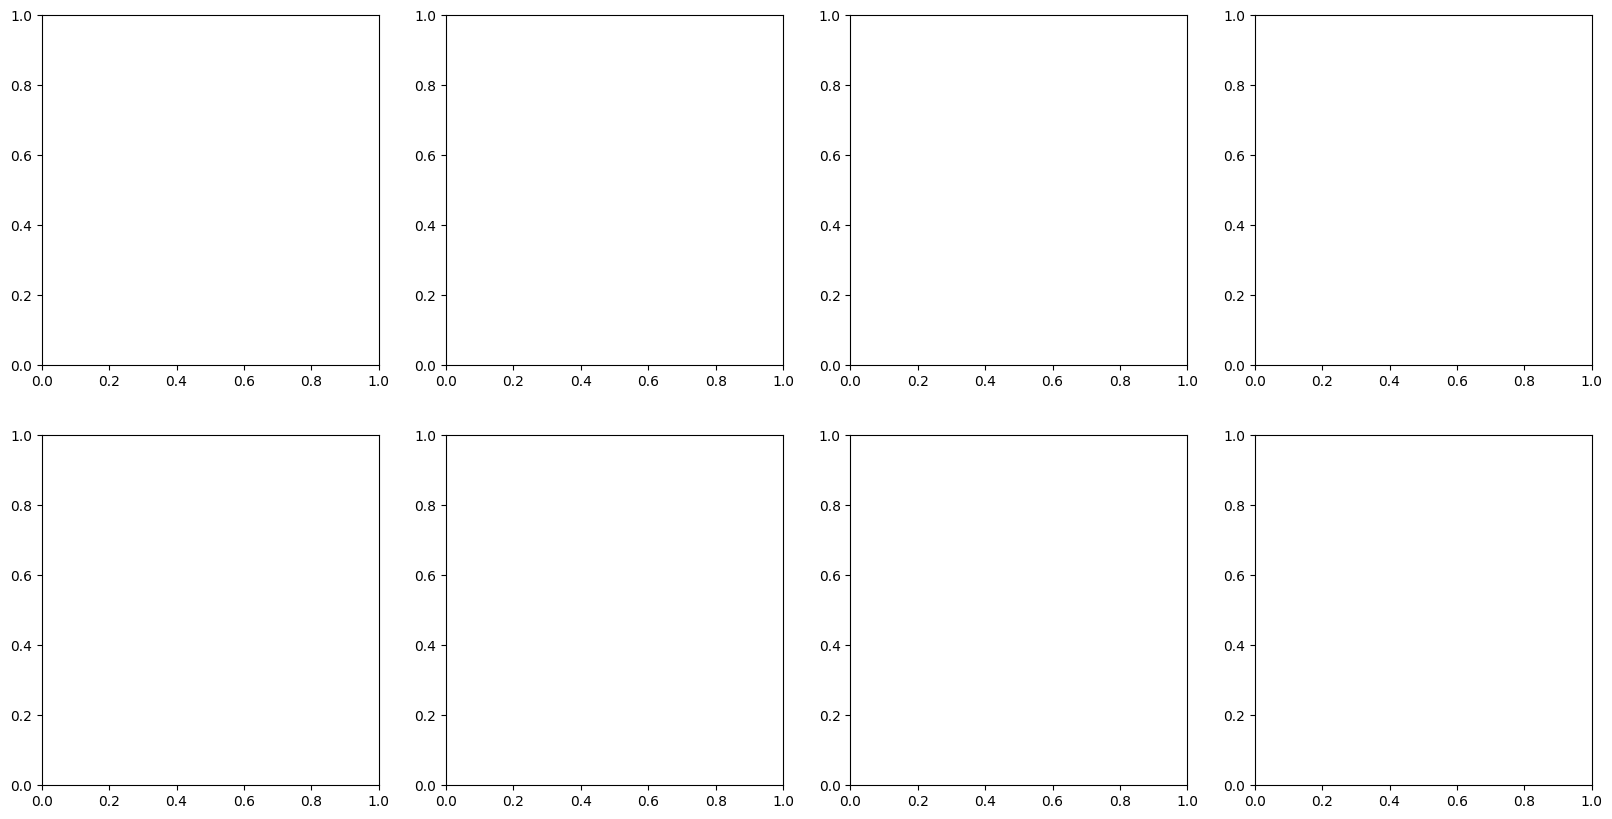

In [ ]:
display_aligned_images()

#Подготовка данные для следующего задания

Обученная модель с наилучшими метриками val_loss

In [ ]:
model = HourglassNet().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_keypoints.pth', weights_only=True))

<All keys matched successfully>

Специальный датасет, содержащий имя изображения (нужно для фильтра всех изображений для 2-го задания)

In [ ]:
class NamedCelebADataset(Dataset):
    def __init__(self, img_dir, img_names, transform=None):
        super().__init__()
        self.img_dir = img_dir
        self.transform = transform
        self.image_names = img_names

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_name

Для 2-го задания берем 75% от датасета CelebA, преобразуем (выравниваем и кропаем по ключевым точкам) обученной моделью, сохраняем в архив и используем в следующем задании

In [ ]:
transform2 = transforms.Compose([
    transforms.Resize((NEW_SIZE, NEW_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

named_dataset = NamedCelebADataset(
    img_dir='/content/celeba/img_align_celeba',
    transform=transform2,
    img_names = updated_df.index.to_list()
)
named_subset_size = int(len(named_dataset) * 0.75)
indices2 = list(range(named_subset_size))
random.shuffle(indices2)
total_subset = Subset(named_dataset,indices2)
loader = DataLoader(total_subset)

@torch.no_grad()
def transform_images(loader, model):
    total_res = []

    for i, (image, name) in enumerate(tqdm(loader, leave=False)):
        model.eval()
        image = image.to(device)
        outputs = model(image)
        pred_heatmaps = outputs[-1]
        img = image[0]
        img_vis = TF.to_pil_image(torch.clamp((img + 1) / 2, 0, 1))
        pred = pred_heatmaps[0]
        pred_coords = heatmap_to_coords(pred)
        img_pil = TF.to_pil_image(torch.clamp((img + 1) / 2, 0, 1))
        img_np = np.array(img_pil)
        aligned_image = torch.tensor(align_face(img_np,pred_coords)).permute(2,0,1)
        aligned_image = aligned_image.float() / 255.0

        file_path = os.path.join('/content/stage_3_dataset', name[0])
        vutils.save_image(aligned_image,file_path)



In [ ]:
transform_images(loader, model)

  0%|          | 0/151949 [00:00<?, ?it/s]

In [ ]:
!zip -r /content/file.zip /content/stage_3_dataset


Streaming output truncated to the last 5000 lines.
  adding: content/stage_3_dataset/112660.jpg (deflated 6%)
  adding: content/stage_3_dataset/129052.jpg (deflated 6%)
  adding: content/stage_3_dataset/151389.jpg (deflated 5%)
  adding: content/stage_3_dataset/118111.jpg (deflated 5%)
  adding: content/stage_3_dataset/000174.jpg (deflated 5%)
  adding: content/stage_3_dataset/013829.jpg (deflated 5%)
  adding: content/stage_3_dataset/107408.jpg (deflated 4%)
  adding: content/stage_3_dataset/112157.jpg (deflated 5%)
  adding: content/stage_3_dataset/119239.jpg (deflated 6%)
  adding: content/stage_3_dataset/120061.jpg (deflated 6%)
  adding: content/stage_3_dataset/147590.jpg (deflated 6%)
  adding: content/stage_3_dataset/037708.jpg (deflated 6%)
  adding: content/stage_3_dataset/072505.jpg (deflated 6%)
  adding: content/stage_3_dataset/100668.jpg (deflated 5%)
  adding: content/stage_3_dataset/118256.jpg (deflated 5%)
  adding: content/stage_3_dataset/121771.jpg (deflated 6%)
  add

In [ ]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>